In [1]:
from ensemble_lstm import AutoLSTM
from ensemble_cnn import AutoCNN
from ensemble_rf import AutoRF

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime

from scipy.signal import savgol_filter

from sklearn.metrics import r2_score, mean_squared_error
import copy

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
tf.get_logger().setLevel('INFO')

seed_value= 2
tf.random.set_seed(seed_value)

lags = [24]*24
lags_cnn = [12]*12+[24]*12

leads = range(1,24+1)

In [5]:
cnn_model = AutoCNN(data_name='data_1107.xlsx', target_name='SP500-EPS-Index')
cnn_model.run(use_target=True, lags=lags_cnn, leads=leads)
cnn_p, cnn_t = cnn_model.get_backtesting()

rf_model = AutoRF(data_name='data_1107.xlsx', target_name='SP500-EPS-Index')
rf_model.run(lags=lags, leads=leads)
rf_p, rf_t = rf_model.get_backtesting()

lstm_model = AutoLSTM(data_name='data_1107.xlsx', target_name='SP500-EPS-Index')
lstm_model.run(use_target=True, lags=lags, leads=leads)
lstm_p, lstm_t = lstm_model.get_backtesting()


In [6]:
result_list = []
true_list = []
cnt_list = []

for i in range(len(leads)):
    cnn_p_cut = cnn_p[i]
    cnn_t_cut = cnn_t[i]
    if i < 12:
        cnn_p_cut = cnn_p_cut[12:]
        cnn_t_cut = cnn_t_cut[12:]
    
    combined_df = pd.DataFrame({'SP500-EPS_CNN_Pred':cnn_p_cut, 'SP500-EPS_LSTM_Pred':lstm_p[i], 'Period_RF_Pred':rf_p[i]})

    result = [(combined_df.iloc[0]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[0]['SP500-EPS_CNN_Pred'])/2]
    cnt = 0

    for index in range(1, len(combined_df)):
        if combined_df.iloc[index]['Period_RF_Pred'] != combined_df.iloc[index-1]['Period_RF_Pred']:
            cnt += 1
        if combined_df.iloc[index]['Period_RF_Pred'] == 0:
            if (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] > result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] > result[index-1]):
                    result.append(result[-1])
            elif (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] < result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] < result[index-1]):
                    tmp = (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result.append(tmp)
            else:
                result.append(min(combined_df.iloc[index]['SP500-EPS_CNN_Pred'], combined_df.iloc[index]['SP500-EPS_LSTM_Pred']))
        else:
            if (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] > result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] > result[index-1]):
                    tmp = (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result.append(tmp)
            elif (combined_df.iloc[index]['SP500-EPS_CNN_Pred'] < result[index-1]) and (combined_df.iloc[index]['SP500-EPS_LSTM_Pred'] < result[index-1]):
                    result.append(result[-1])
            else:
                result.append(max(combined_df.iloc[index]['SP500-EPS_CNN_Pred'], combined_df.iloc[index]['SP500-EPS_LSTM_Pred']))
    
    result_list.append(result)
    true_list.append(cnn_t_cut)
    cnt_list.append(cnt)

In [7]:

# d = np.arange ('1971-07', '2020-10', np.timedelta64 (1,'M'), dtype='datetime64')
# d = d.astype('datetime64[D]') 


# for i in range(len(leads)):

#     poly_fun = np.polyfit(list(range(len(result_list[i]))), result_list[i], cnt_list[i]+20, rcond=None, full=False, w=None, cov=False)
#     p = np.poly1d(poly_fun)
#     smooth = p(list(range(len(result_list[i]))))

#     r_square_s = r2_score(smooth, true_list[i])
#     r_square_ori = r2_score(result_list[i], true_list[i])
    
#     rmse_s = np.sqrt(mean_squared_error(smooth, true_list[i]))
#     rmse_ori = np.sqrt(mean_squared_error(result_list[i], true_list[i]))

#     s1 = "r2 of smoothed: "+ str(np.round(r_square_s, 2)) + "  r2 of original: "+ str(np.round(r_square_ori, 2))
#     s2 = "rmse of smoothed: "+ str(np.round(rmse_s, 2)) + "  rmse of original: "+ str(np.round(rmse_ori, 2))

#     d_i = d[i:]

#     plt.figure(figsize=(15, 6))

#     plt.plot(d_i, result_list[i], label='lead ' + str(i+1), alpha=0.5)
#     plt.plot(d_i, smooth, label='smooth')
#     plt.plot(d_i, true_list[i], label='actual', linestyle='dashed')
#     plt.title(s1 + " " + s2)
#     plt.legend()
#     plt.show()


In [7]:
full_result_list = copy.deepcopy(result_list)
actual = true_list[0]

# insert none to first 23 lead
for i in range(len(leads)):
    for j in range(i):
        full_result_list[i].insert(0, np.nan)

np_full_result_list = np.array(full_result_list)
mean = np.nanmean(np_full_result_list, axis=0)

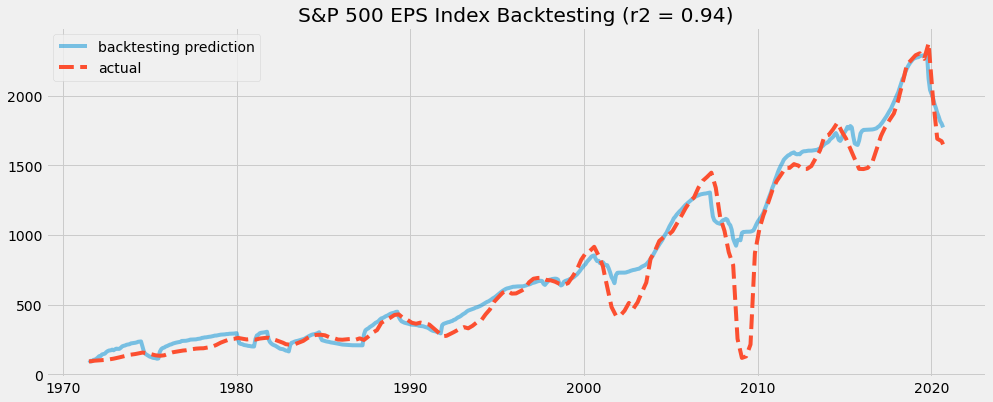

In [9]:
d = np.arange ('1971-07', '2020-10', np.timedelta64 (1,'M'), dtype='datetime64')
d = d.astype('datetime64[D]') 

r_square_ori = r2_score(mean, actual)

s = 'S&P 500 EPS Index Backtesting ' + '(r2 = ' + str(np.round(r_square_ori,2)) + ')'
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 6))
plt.plot(d, mean, label='backtesting prediction', alpha=0.5)
plt.plot(d, actual, label='actual', linestyle='dashed')
plt.title(s)
plt.legend(loc = 0)
plt.show()

### 24 Months Forecasting

In [39]:
def get_single_forecasting(last_month):
    cnn_future, cnn_actual = cnn_model.get_predict(last_month)
    lstm_future, lstm_actual = lstm_model.get_predict(last_month)
    rf_future, rf_actual = rf_model.get_predict(last_month)
    combined_df_future = pd.DataFrame({'SP500-EPS_CNN_Pred':cnn_future, 'SP500-EPS_LSTM_Pred':lstm_future, 'Period_RF_Pred':rf_future})
    result_future = [(combined_df_future.iloc[0]['SP500-EPS_LSTM_Pred'] + combined_df_future.iloc[0]['SP500-EPS_CNN_Pred'])/2]

    for index in range(1, len(combined_df_future)):

        if combined_df_future.iloc[index]['Period_RF_Pred'] == 0:
            if (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] > result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] > result_future[index-1]):
                    result_future.append(result_future[-1])
            elif (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] < result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] < result_future[index-1]):
                    tmp = (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result_future.append(tmp)
            else:
                result_future.append(min(combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'], combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred']))
        else:
            if (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] > result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] > result_future[index-1]):
                    tmp = (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] + combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'])/2
                    result_future.append(tmp)
            elif (combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'] < result_future[index-1]) and (combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred'] < result_future[index-1]):
                    result_future.append(result_future[-1])
            else:
                result_future.append(max(combined_df_future.iloc[index]['SP500-EPS_CNN_Pred'], combined_df_future.iloc[index]['SP500-EPS_LSTM_Pred']))
    
    
    
    plt_date_start = np.array(last_month,dtype=np.datetime64) + 1
    plt_date_end = np.array(last_month,dtype=np.datetime64) + 25
    d = np.arange (plt_date_start, plt_date_end, np.timedelta64 (1,'M'), dtype='datetime64')
    d = d.astype('datetime64[D]') 
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(15, 6))
    plt.plot(d, result_future, label='forecasting')
    
    title = 'S&P 500 EPS Index 24 Months Forecasting'
    if len(cnn_actual) > 0:
        plt.plot(d, cnn_actual, label='actual')
        rmse = np.sqrt(mean_squared_error(result_future, cnn_actual, squared=False))
        r2 = r2_score(result_future, cnn_actual)
        title = 'S&P 500 EPS Index 24 Months Forecasting (r2 = ' +  str(np.round(r2,2)) + ', rmse = ' + str(np.round(rmse,2)) + ')'
    
    plt.legend() 
    plt.title(title)
    plt.show()

    return result_future

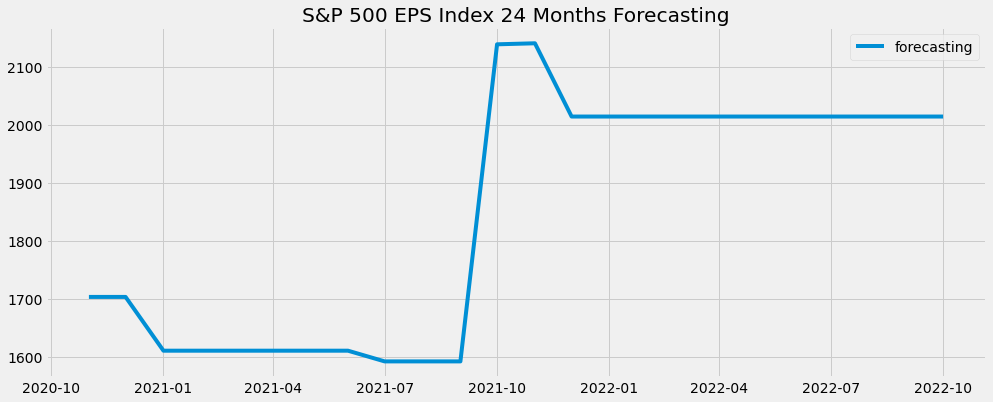

In [35]:
result_future = get_single_forecasting('2020-10')

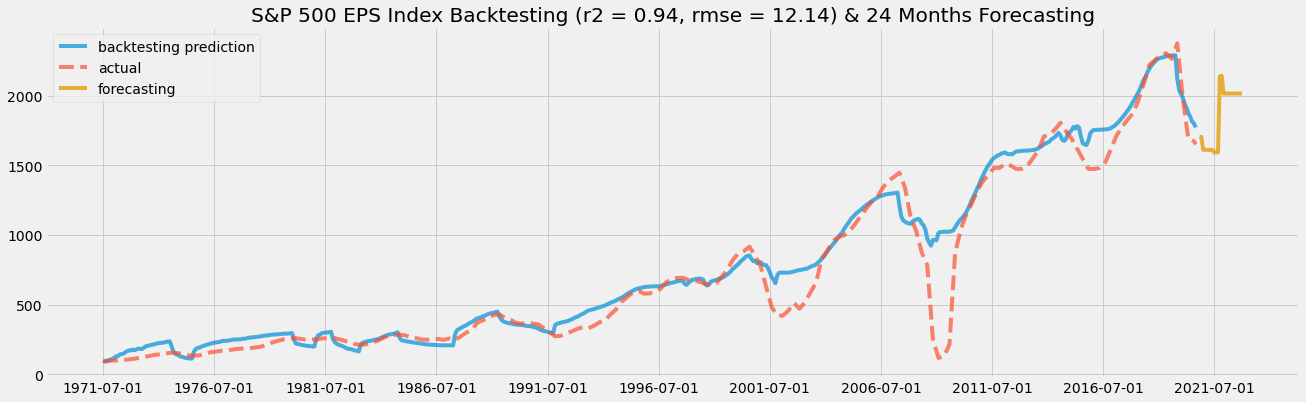

In [38]:
d = np.arange ('1971-07', '2020-10', np.timedelta64 (1,'M'), dtype='datetime64')
d = d.astype('datetime64[D]') 

d_future = np.arange ('2020-11', '2022-11', np.timedelta64 (1,'M'), dtype='datetime64')
d_future = d_future.astype('datetime64[D]') 

r_square_ori = r2_score(mean, actual)
rms = np.sqrt(mean_squared_error(mean, actual, squared=False))
s = 'S&P 500 EPS Index Backtesting' + ' (r2 = ' + str(np.round(r_square_ori,2)) + ', rmse = ' + str(np.round(rms,2)) + ')' + ' & 24 Months Forecasting'

plt.figure(figsize=(20, 6))
plt.plot(d, mean, label='backtesting prediction', alpha=0.7)
plt.plot(d, actual, label='actual', alpha = 0.7, linestyle='dashed')
plt.plot(d_future, result_future, label='forecasting')
plt.xticks(np.arange ('1971-07', '2022-11', np.timedelta64 (60,'M'), dtype='datetime64'))
plt.title(s)
plt.legend(loc = 0)
plt.show()

### Forecasting Method Backtesting

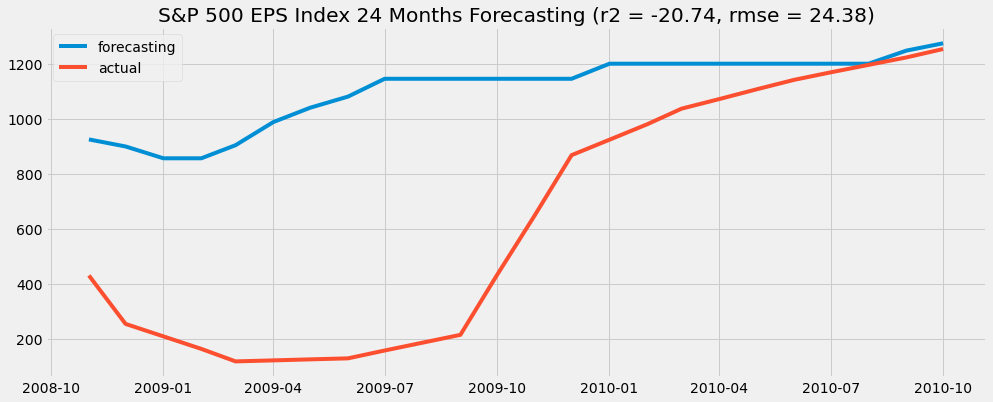

In [40]:
bt_result1 = get_single_forecasting('2008-10')

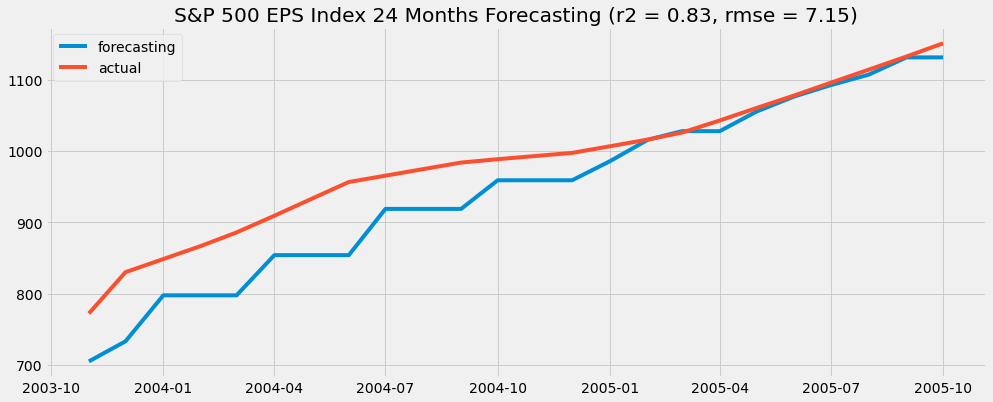

In [41]:
bt_result1 = get_single_forecasting('2003-10')

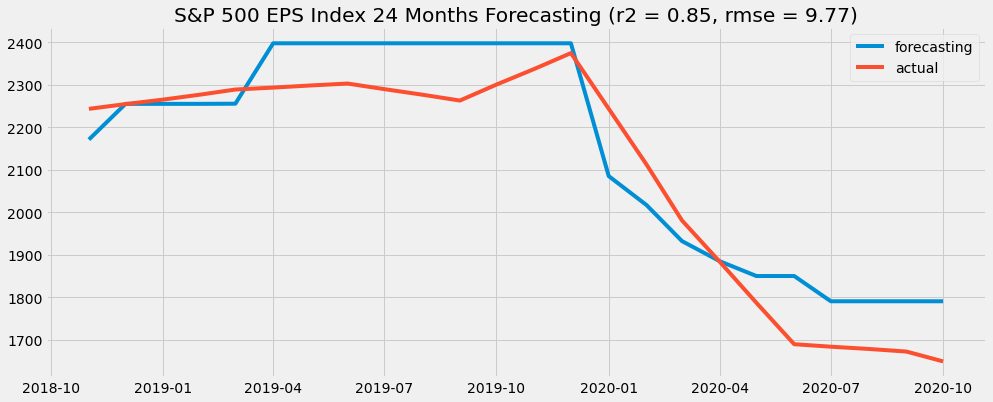

In [42]:
bt_result1 = get_single_forecasting('2018-10')

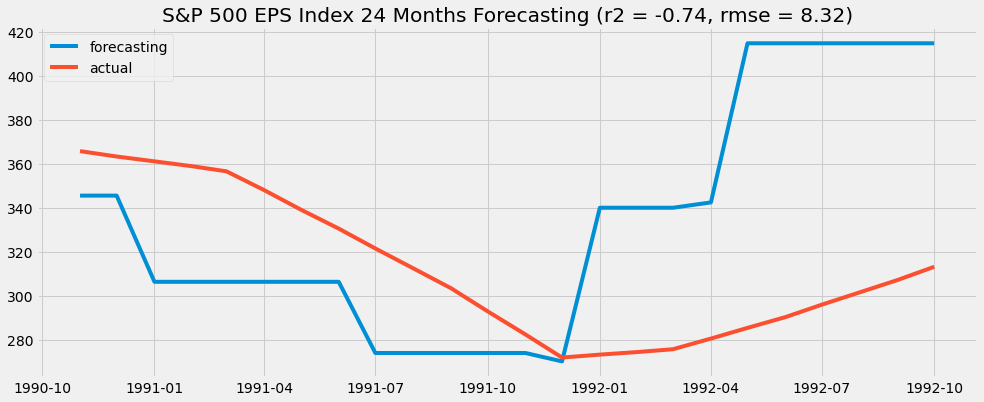

In [43]:
bt_result1 = get_single_forecasting('1990-10')